In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
from physoce import tseries as ts
import matplotlib.lines as mlines

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

ds

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


<xarray.Dataset>
Dimensions:                         (bin: 30, obs: 8921)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * obs                             (obs) int32 0 1 2 3 ... 8917 8918 8919 8920
Data variables: (12/49)
    ensemble_number                 (obs) float32 ...
    transducer_depth                (obs) float32 ...
    pitch                           (obs) float32 ...
    cell_length                     (obs) float32 ...
    driver_timestamp                (obs) datetime64[ns] ...
    id                              (obs) |S64 ...
    ...                              ...
    corrected_echo_intensity_beam4  (obs, bin) float64 ...
    eastward_seawater_velocity      (obs, bin) float64 ...
    northward_seawater_velocity     (obs, bin) float64 ...
    upward_seawater_velocity        (obs, bin) float64 ...
    error_seawater_velocity         (obs, bin) float64 ...
    bin_depths                      (obs, bin) float64 ...
Attributes: (12/72)
    node:                               MFD35
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    lat:                                44.65683
    lon:                                -124.09533
    DODS.strlen:                        18
    DODS.dimName:                       string18

(18078.0, 18108.0)

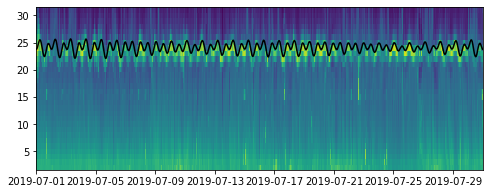

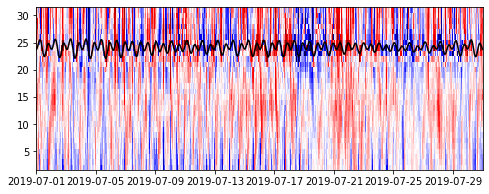

In [2]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-31 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.xlim([t1,t2])

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.xlim([t1,t2])

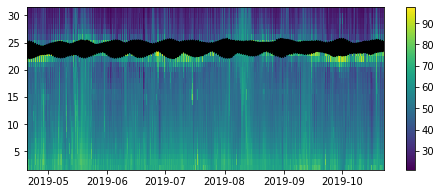

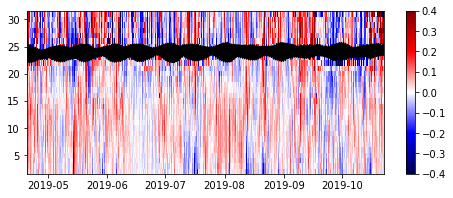

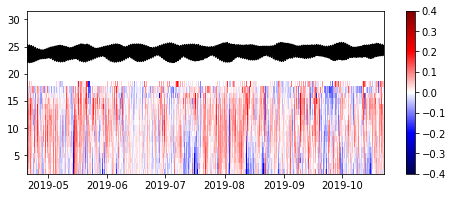

In [3]:
good = (ds['bin_depths'] > 7)

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

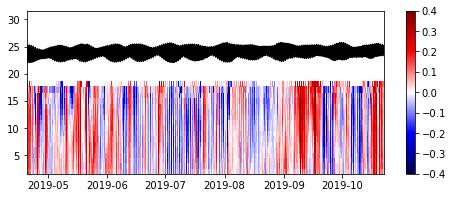

In [4]:
t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-15 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['v'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()

perform depth averaging using physoce time series

Text(0, 0.5, '[m/s]')

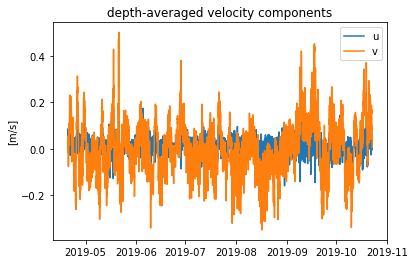

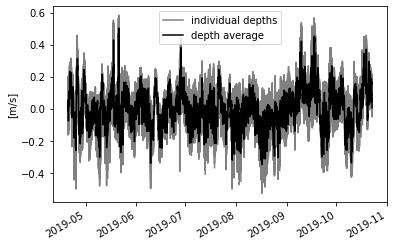

In [5]:
uda = ts.depthavg(ds['u'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

plt.figure()
plt.plot(ds['time'],ds['uda'])
plt.plot(ds['time'],ds['vda'])
plt.legend(['u','v'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

plt.figure()
h1 = plt.plot(ds['time'],ds['v'].where(good),color='gray', label='individual depths')
h1handle = mlines.Line2D([], [], color='gray', label='individual depths')
h2 = plt.plot(ds['time'],ds['vda'],color='k', label='depth average')
h2handle = mlines.Line2D([], [], color='k', label='depth average')
plt.gcf().autofmt_xdate()
plt.legend(handles=[h1handle, h2handle])
plt.ylabel('[m/s]')

rotate northern and eastern components into crossshore and alongshore directions using principal axis analysis

(18048.0, 18138.0)

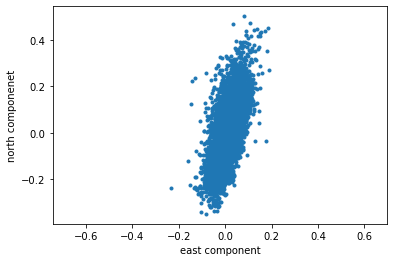

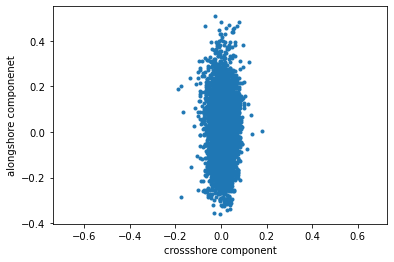

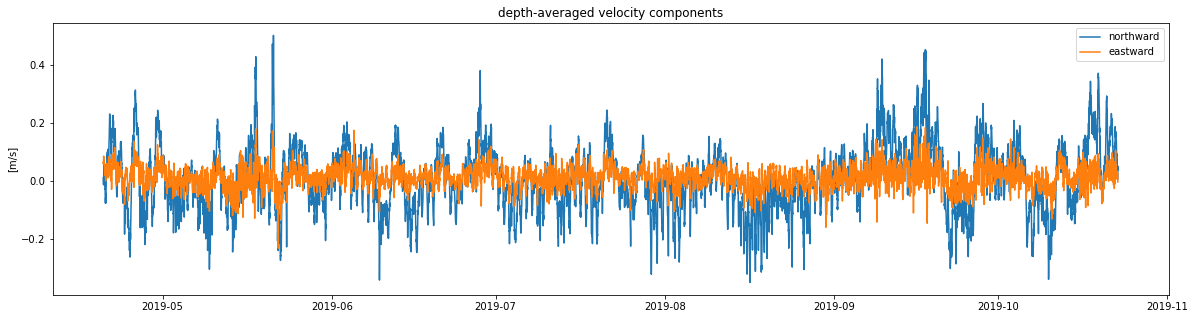

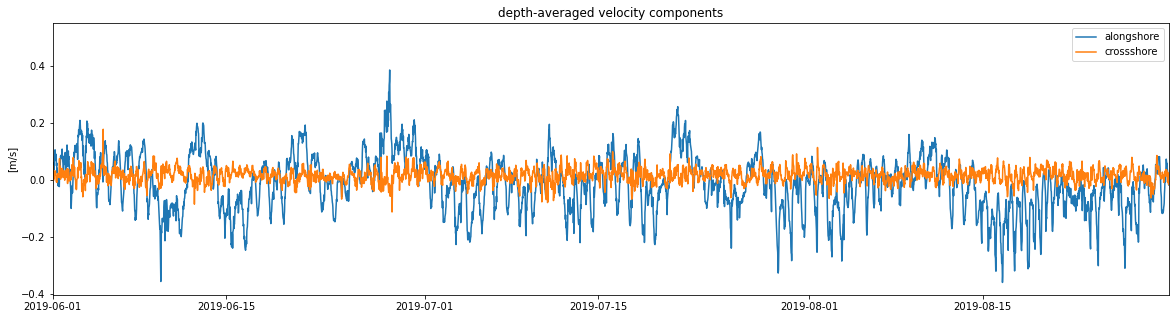

In [6]:

ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

ds['bin_depths_avg']

uda = ts.depthavg(ds['u'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds['uda'],ds['vda'])
ds['cs_da'],ds['as_da'] = rot(ds['uda'],ds['vda'],-theta+90)

t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-30 00:00:00')

plt.figure()
plt.plot(ds['uda'], ds['vda'], linestyle='none', marker='.')
plt.xlabel('east component')
plt.ylabel('north componenet')
plt.axis('equal')

plt.figure()
plt.plot(ds['cs_da'], ds['as_da'], linestyle='none', marker='.')
plt.xlabel('crossshore component')
plt.ylabel('alongshore componenet')
plt.axis('equal')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['vda'])
plt.plot(ds['time'],ds['uda'])
plt.legend(['northward','eastward'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['as_da'])
plt.plot(ds['time'],ds['cs_da'])
plt.legend(['alongshore','crossshore'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')
plt.xlim([t1,t2])